In [1]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import tensorflow as tf
# from tensorflow import keras
import cv2
import snappy
import numpy as np
import random as rn
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
np.random.seed(4321)
rn.seed(4321)
tf.random.set_seed(4321)

In [80]:
mask_file_name = r'\water_mask_R019_T43PGQ.npy'
water_veg_mask = np.load(r'D:\workspace\jupyterNotebooks\Remote Sensing\Water-Segmentation\data'+mask_file_name)
water_veg_mask = water_veg_mask.flatten()

In [81]:
unique, counts = np.unique(water_veg_mask, return_counts=True)
print(unique, counts)

[0 1] [628897  25584]


In [82]:
product_file_name = '\subset_1_of_S2A_MSIL2A_20190104T051211_N0211_R019_T43PGQ_20190104T094623_resampled.dim'
product_path = r'D:\Datasets\satellite\CVMI'+product_file_name

In [83]:
product = snappy.ProductIO.readProduct(product_path)
width = product.getSceneRasterWidth()
height = product.getSceneRasterHeight()

In [84]:
# B2 = product.getBand('B2')
# B3 = product.getBand('B3_S')
# B4 = product.getBand('B4_S')
# B5 = product.getBand('B5')
# B6 = product.getBand('B6')
# B7 = product.getBand('B7_S')
# B8 = product.getBand('B8_S')
B8A = product.getBand('B8A')
B11 = product.getBand('B11')
B12 = product.getBand('B12')

In [85]:
# B2_pixels = np.zeros(width * height, np.float32)
# B2.readPixels(0,0,width,height,B2_pixels)
# # B2_pixels.flatten()

# B3_pixels = np.zeros(width * height, np.float32)
# B3.readPixels(0,0,width,height,B3_pixels)
# B3_pixels.flatten()
# 
# B4_pixels = np.zeros(width * height, np.float32)
# B4.readPixels(0,0,width,height,B4_pixels)
# B4_pixels.flatten()

# B5_pixels = np.zeros(width * height, np.float32)
# B5.readPixels(0,0,width,height,B5_pixels)

# B6_pixels = np.zeros(width * height, np.float32)
# B6.readPixels(0,0,width,height,B6_pixels)

# B7_pixels = np.zeros(width * height, np.float32)
# B7.readPixels(0,0,width,height,B7_pixels)

# B8_pixels = np.zeros(width * height, np.float32)
# B8.readPixels(0,0,width,height,B8_pixels)
# B8_pixels.flatten()

B8A_pixels = np.zeros(width * height, np.float32)
B8A.readPixels(0,0,width,height,B8A_pixels)

B11_pixels = np.zeros(width * height, np.float32)
B11.readPixels(0,0,width,height,B11_pixels)

B12_pixels = np.zeros(width * height, np.float32)
B12.readPixels(0,0,width,height,B12_pixels)

array([0.1082, 0.1082, 0.1175, ..., 0.1923, 0.1923, 0.1624], dtype=float32)

In [86]:
X_val = pd.DataFrame({
#                 'B2':B2_pixels, 
#                    'B3': B3_pixels,
#                    'B4': B4_pixels,
#                    'B5': B5_pixels,
#                    'B6': B6_pixels,
#                    'B7': B7_pixels,
#                    'B8': B8_pixels,
#                    'B8A': B8A_pixels,
                   'B11': B11_pixels,
#                    'B12': B12_pixels,
                    })
X_val.shape

(654481, 1)

In [87]:
def create_model():
    model = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(1,)),
#             tf.keras.layers.experimental.preprocessing.Normalization(),
            tf.keras.layers.Dense(32, activation="relu"),
#             tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dropout(0.4),
#             tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(1, activation="sigmoid")
            
            
        ]
        )
    model.compile(
        loss=[tf.keras.losses.BinaryCrossentropy()],
        optimizer=tf.keras.optimizers.Adam(1e-4),
        metrics=[tf.keras.metrics.BinaryAccuracy()],
    )
    return model

In [88]:
model = create_model()
model.load_weights('D:\workspace\jupyterNotebooks\Remote Sensing\Water-Segmentation\data\9_B11_ANN_S_BC')

In [89]:
def make_map(array):
    res = [[0,0,0] for i in range(len(array))]
    for i in range(len(array)):
        if(array[i] == 1):
            res[i] = [0,0,255]
    return res

In [90]:
image = make_map(water_veg_mask)
image = np.array(image)
image = np.reshape(image, (809,809,3))

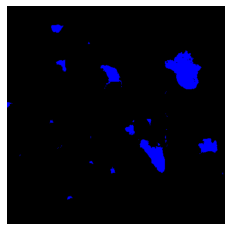

In [91]:
plt.imshow(image)
plt.axis('off')
plt.show()

In [92]:
clf_y_pred = model.predict(X_val)
clf_y_pred = [1 if x > 0.5 else 0 for x in clf_y_pred]
clf_y_pred = np.array(clf_y_pred)

In [93]:
pred_image = make_map(clf_y_pred)
pred_image = np.array(pred_image)
pred_image = np.reshape(pred_image, (809,809,3))

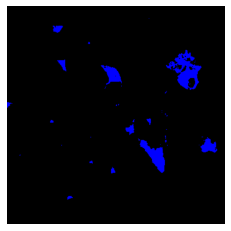

In [94]:
plt.imshow(pred_image)
plt.axis('off')
plt.show()

In [95]:
def show_confusion_matrix(y_test, y_pred, score):    
    cm = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);
    return cm
def get_miou(cm):
    col_sums = cm.sum(axis=0)
    row_sums = cm.sum(axis=1)
    iou = 0.0
    c = 0
    for i in range(len(cm)):
        tp = cm[i,i]
        denominator = (col_sums[i]+row_sums[i] - tp)
        if denominator != 0:
            c +=1
            iou += tp/denominator
    return iou/c
def find_padding(v, divisor=32):
    v_divisible = max(divisor, int(divisor * np.ceil( v / divisor )))
    total_pad = v_divisible - v
    pad_1 = total_pad // 2
    pad_2 = total_pad - pad_1
    return pad_1, pad_2

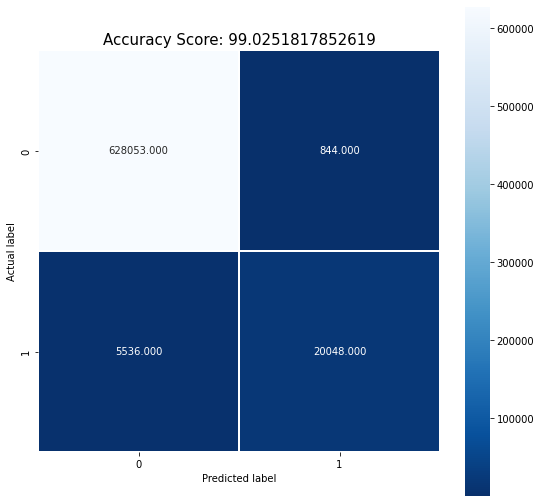

In [96]:
length=len(clf_y_pred)
# predict_label_ak=np.argmax(clf_y_pred,axis=1)

accuracy_ak=np.sum(water_veg_mask==clf_y_pred)/length * 100 

cm = show_confusion_matrix(y_test = water_veg_mask, y_pred = clf_y_pred, score = accuracy_ak)

In [97]:
ann_miou = get_miou(cm)
print(ann_miou)

0.8742665757372015
